In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection


BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205

In [35]:
df = pd.read_csv('DS_2_train.csv', index_col=0)

In [36]:
df.head()

,event_id,X,Y,Z,TX,TY,chi2,signal,brick_number
index,,,,,,,,,
0,35130,50550.007812,66924.796875,65943.0,0.639179,-0.086816,0.583319,1.0,53
1,-999,48811.390625,65584.648438,12930.0,0.569996,0.294196,1.582101,0.0,49
2,-999,30120.525391,28329.425781,21981.0,-0.366648,-0.379520,1.292502,0.0,39
3,-999,67186.773438,23033.931641,68529.0,-0.434561,0.502130,2.832125,0.0,65
4,-999,64832.343750,64279.328125,7758.0,0.139993,-0.417299,2.959314,0.0,13


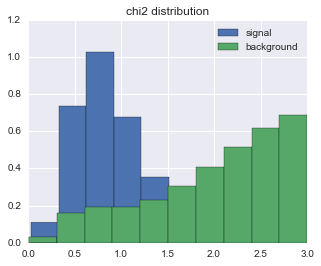

In [37]:
plt.figure(dpi = 80, figsize=(5,4))
first = plt.hist(df.chi2[df.signal == True], normed = True, label = 'signal')
second = plt.hist(df.chi2[df.signal == False], normed = True, label = 'background')
plt.title('chi2 distribution')
plt.legend()
plt.show()

In [38]:
def plot_bg_and_mc(pbg, pmc, id=0, step=1):
    df = pbg
    # mind the order!
    d0 = pd.DataFrame([
                df['Z'][::step],
                df['X'][::step],
                df['Y'][::step]],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['TX'][::step]*dZ,
            df['TY'][::step]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    # print d0, d1
    C = plt.cm.Blues(0.5)
    lc_bg = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.5, lw=2)

    df = pmc

    # mind the order!
    d0 = pd.DataFrame([
                df['Z'],
                df['X'],
                df['Y']],
                index=['z', 'x', 'y']).T
    numtracks = d0.shape[0]
    dd = pd.DataFrame([
            df['TX']*dZ,
            df['TY']*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d1 = d0 + dd
    print(d1.shape)
    #print (d0)§
    C = plt.cm.Reds(0.5)
    lc_mc = Line3DCollection(list(zip(d0.values, d1.values)), colors=C, alpha=0.9, lw=2)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-50, elev=10)
    ax.add_collection3d(lc_mc)
    ax.add_collection3d(lc_bg)
    
    # mind the order!
    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")  
    ax.set_xlim(0, BRICK_Z)
    ax.set_ylim(0, BRICK_X)
    ax.set_zlim(0, BRICK_Y)

(2939, 3)


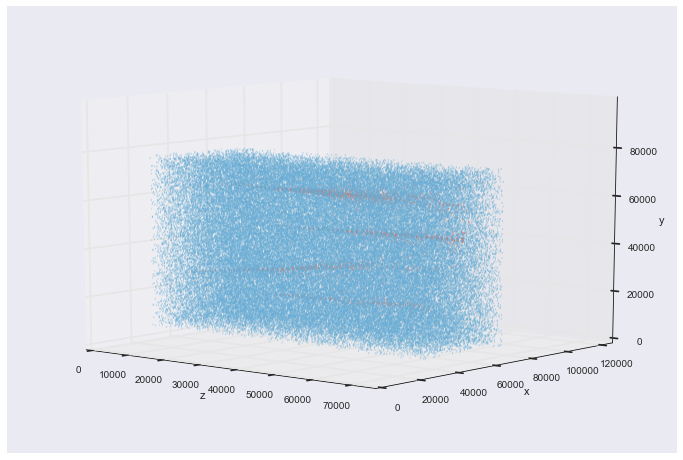

In [39]:
%matplotlib inline
plot_bg_and_mc(df[np.logical_and(df.brick_number == 1, df.signal == 0)], df[np.logical_and(df.brick_number == 1, df.signal == 1)])

In [40]:
train_df = df[df.signal == True].values[:, 1:8]
print len(train_df)

162209


In [41]:
train_df = np.concatenate([train_df, df[df.signal == False].values[:150000, 1:8]])

In [42]:
len(train_df)

312209

In [43]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = 5, n_estimators = 100, n_jobs = -1)

In [44]:
clf.fit(train_df[:, :-1], np.array(train_df[:, -1], dtype = int))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [45]:
df_test = pd.read_csv('DS_2_test.csv', index_col=0)

In [46]:
df_test.head()

,X,Y,Z,TX,TY,chi2,brick_number
index,,,,,,,
0,57690.351562,40314.937500,47841.0,-0.268973,0.039472,1.113268,9
1,37949.566406,72453.781250,50427.0,0.092281,-0.026488,2.673564,87
2,42897.289062,16920.482422,19395.0,-0.069568,0.044336,2.672163,38
3,54251.625000,48776.027344,20688.0,0.175112,-0.184691,2.369353,39
4,62038.414062,26468.835938,25860.0,-0.259970,-0.155785,2.490212,36


In [47]:
prediction = clf.predict_proba(df_test.values[:, :-1])[:, 1]

In [49]:
baseline = pd.DataFrame(prediction, columns=['Prediction'])
baseline.index.name = 'Id'
baseline.to_csv('baseline.csv', header=True)